# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

from collections import defaultdict

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {v: k for k, v in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        word_sims = np.apply_along_axis(lambda x: self.score(w, x), 1, self.embeddings)
        idx = np.argsort(-word_sims)[:K]
        words = [self.id2word[my_id] for my_id in idx]
        return words

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        embed1 = self.word2vec[w1] if type(w1) == str else w1
        embed2 = self.word2vec[w2] if type(w2) == str else w2
        return np.dot(embed1, embed2) / (np.linalg.norm(embed1) * np.linalg.norm(embed2))

In [5]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288558
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'parisian', 'london']
['germany', 'austria', 'europe', 'german', 'berlin']


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []

        for sent in sentences:
            # invert each word to the correponding embedding
            words = sent.split()
            if idf is False:
                # return mean embedding
                sent_emb = np.vstack([self.w2v.word2vec[word] for word in words if word in self.w2v.word2vec])
                sentemb.append(sent_emb.mean(0))
            else:
                # return idf-weighted mean of word vectors
                sent_emb = np.vstack([self.w2v.word2vec[word] for word in words if word in self.w2v.word2vec])
                sent_weights = [idf.get(word, 0) for word in words if word in self.w2v.word2vec]
                sentemb.append(np.ma.average(sent_emb, axis = 0, weights = sent_weights))
                
        return np.squeeze(np.vstack(sentemb))

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        sent_sims = np.apply_along_axis(lambda x: self.score(query, x, idf), 1, keys)
        idx = np.argsort(-sent_sims)[:K]
        sents = [sentences[my_id] for my_id in idx]
        
        return sents

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        code1 = self.encode([s1], idf) if type(s1) == str else s1
        code2 = self.encode([s2], idf) if type(s2) == str else s2
        return np.dot(code1, code2) / (np.linalg.norm(code1) * np.linalg.norm(code2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        N = float(len(sentences))

        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
                
        idf = dict(map(lambda item: (item[0], max(1, np.log10(N / item[1]))), idf.items()))
        # max(1, np.log10(len(sentences) / (idf[word])))
        return idf

In [8]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt'), "r") as fp:
    sentences = fp.read().split("\n")[:-1]

# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

idf = s2v.build_idf(sentences) 
print(s2v.most_similar('' if not sentences else sentences[10], sentences, idf)) # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 200000 pretrained word vectors
['1 smiling african american boy . ', 'an african american man smiling . ', 'a little african american boy and girl looking up . ', 'an afican american woman standing behind two small african american children . ', 'an african american man is sitting . ']
0.5726258859719607
['1 smiling african american boy . ', 'an african american man smiling . ', 'an african american man is sitting . ', 'a little african american boy and girl looking up . ', 'an afican american woman standing behind two small african american children . ']
0.4751450875368781


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [ ]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
!curl -Lo data/wiki.en.vec https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
!curl -Lo data/wiki.fr.vec https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

In [5]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

def get_identical_words(file_en, file_fr, max_len = 1000000):
    """Find identical words in two vector gloves
    
    Params:
        file_en: the english word embedding
        file_fr: the french word embedding
        max_len: maximum identical word number
        
    Return:
        id_words: a dict mapping word to index
    """
    
    words = defaultdict(int)
    
    with open(file_fr, "r") as fp:
        next(fp)
        for line in fp:
            words[line.split(' ')[0]] += 1
            
    with open(file_en, "r") as fp:
        next(fp)
        for line in fp:
            word = line.split(' ')[0]
            if word in words:
                words[word] += 1
                
    id_words = [key for key, val in words.items() if val == 2]

    if len(id_words) > max_len:
        id_words = id_words[:max_len]

    return dict(zip(id_words, range(len(id_words))))


def get_identical_vecs(file_en, file_fr, id_words, vec_len = 300):
    """Load vector embeddings given identical words
    
    Params:
        file_en: the english word embedding
        file_fr: the french word embedding
        id_words: a dict mapping word to index
        vec_len: the feature dimension for each embedding
    
    Returns:
        mat_en: (vec_len, num_words), the embedding for english words
        mat_fr: (vec_len, num_words), the embedding for french words
    """
    
    num_words = len(id_words)
    mat_en, mat_fr = np.zeros((num_words, vec_len)), np.zeros((num_words, vec_len))
    
    with open(file_en, "r") as fp:
        next(fp)
        for line in fp:
            word, vec = line.split(' ', 1)
            if word in id_words:
                mat_en[id_words[word]] = np.fromstring(vec, sep = ' ')
    
    with open(file_fr, "r") as fp:
        next(fp)
        for line in fp:
            word, vec = line.split(' ', 1)
            if word in id_words:
                mat_fr[id_words[word]] = np.fromstring(vec, sep = ' ')
                          
    return mat_en.T, mat_fr.T

# file path
file_en = os.path.join(PATH_TO_DATA, 'wiki.en.vec')
file_fr = os.path.join(PATH_TO_DATA, 'wiki.fr.vec')
# load identical embeddings
word_idx = get_identical_words(file_en, file_fr)
mat_en, mat_fr = get_identical_vecs(file_en, file_fr, word_idx)

In [6]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy.linalg import svd

def calc_weight(mat_source, mat_target):
    """Calculate word alignment matrix W
    
    Params:
        mat_source: of size vec_len * num_word
        mat_target: of size vec_len * num_word
        
    Return:
        W: word alignment matrix of size vec_len * vec_len
    """
    U, _, Vh = svd(mat_target.dot(mat_source.T))
    W = U.dot(Vh)
    
    return W

def cosine_similarity(x1, x2):

    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

def find_nearest_neigbors(target, mat_proj, mat_target, dict_idx_word, dict_word_idx, K):
    """Find K nearest neighbors of a word after word alignment
    
    Params:
        target: the target word
        mat_proj: the alignment embedding
        mat_target: the target embedding
        dict_idx_word: a dict mapping index to word
        dict_word_idx: a dict mapping word to index
        K: number of similar words
    
    Returns:
        match_words: the nearest K similar words
    """
    
    idx = dict_word_idx[target]
    vec = mat_proj[:, idx].reshape((-1,))
    
    cos_sim = np.apply_along_axis(lambda x: cosine_similarity(vec, x), 0, mat_target)
    match_idx = np.argsort(-cos_sim)[:K]
    match_words = [dict_idx_word[idx] for idx in match_idx]
    
    return match_words

W_fr_en = calc_weight(mat_fr, mat_en)
proj_fr_en = W_fr_en.dot(mat_fr)

W_en_fr = calc_weight(mat_en, mat_fr)
proj_en_fr = W_en_fr.dot(mat_en)

idx_word = dict(zip(word_idx.values(), word_idx.keys()))

In [11]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

fr_words = ["et", "famille", "france", "ville", "pays"]
en_words = ["speak", "ship", "trip", "zoom", "fat"]

print("French -> English")

for word in fr_words:
    nbs = find_nearest_neigbors(word, proj_fr_en, mat_en, idx_word, word_idx, 5)
    print("Nearest Neighbors for %s: %s" % (word, ", ".join(nbs)))

print("\nEnglish -> French")

for word in en_words:
    nbs = find_nearest_neigbors(word, proj_en_fr, mat_fr, idx_word, word_idx, 5)
    print("Nearest Neighbors for %s: %s" % (word, ", ".join(nbs)))

French -> English
Nearest Neighbors for et: and, couverts, visées, pacifiques, pité
Nearest Neighbors for famille: family, nemouridae, †family, dynastidae, dipluridae
Nearest Neighbors for france: france, francefrance, orléanaise, europe/luxembourg, france»
Nearest Neighbors for ville: city, town, cities, suburb, towns
Nearest Neighbors for pays: countries, netherlands, country, regions, provinces

English -> French
Nearest Neighbors for speak: parlé, parlent, parlée, parler, parlant
Nearest Neighbors for ship: navire, navires, ship, frégate, croiseur
Nearest Neighbors for trip: voyage, excursion, voyagers, périple, excursions
Nearest Neighbors for zoom: zoom, zoomshot, megapixels, superzoom, megapixel
Nearest Neighbors for fat: fat, stuffed, graisse, blowjobs, smoothed


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [5]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def read_file(fp_name, label = True):
    """Read dataset from disk
    
    Params:
        fp_name: the file path
        label: if train/dev, set to True, if test, set to False
        
    Return:
        sentences: dataset
        labels: groundtruth
    
    """
    with open(fp_name, "r") as fp:
        fp_line = fp.read().split("\n")[:-1]
        
        if label:
            labels = np.array([int(line[0]) for line in fp_line])
            sentences = [line[2:] for line in fp_line]
            return sentences, labels
        else:
            return fp_line

train_sents, train_labels = read_file(os.path.join(PATH_TO_DATA, "SST/stsa.fine.train"), True)
dev_sents, dev_labels = read_file(os.path.join(PATH_TO_DATA, "SST/stsa.fine.dev"), True)
test_sents = read_file(os.path.join(PATH_TO_DATA, "SST/stsa.fine.test.X"), False)

In [15]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax = 200000)
s2v = BoV(w2v)

idf = s2v.build_idf(train_sents + dev_sents) 

train_mat = s2v.encode(train_sents)
dev_mat = s2v.encode(dev_sents)
test_mat = s2v.encode(test_sents)

train_mat_idf = s2v.encode(train_sents, idf)
dev_mat_idf = s2v.encode(dev_sents, idf)
test_mat_idf = s2v.encode(test_sents, idf)

Loaded 200000 pretrained word vectors


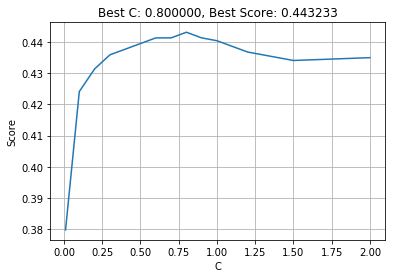

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

def grid_search(lc, train_mat, train_labels, dev_mat, dev_labels):
    
    lscore = []
    
    for c in lc:
        clf = LogisticRegression(C = c, multi_class = "auto", solver = 'lbfgs', max_iter = 500)
        clf.fit(train_mat, train_labels)
        score = clf.score(dev_mat, dev_labels)
        lscore.append(score)
        
    best_score = max(lscore)
    best_c = lc[np.argmax(lscore)]
    
    plt.figure()
    plt.plot(lc, lscore)
    plt.title("Best C: %f, Best Score: %f" % (best_c, best_score))
    plt.xlabel("C")
    plt.ylabel("Score")
    plt.grid()
    plt.show()
    
        
    return best_score, best_c

lc = [0.01, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.2, 1.5, 2.]
_, c = grid_search(lc, train_mat, train_labels, dev_mat, dev_labels)

clf = LogisticRegression(C = c, multi_class = "auto", solver = 'lbfgs', max_iter = 500)
clf.fit(train_mat, train_labels)

In [18]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
test_pred = clf.predict(test_mat)

with open(os.path.join(PATH_TO_DATA, "SST/results/logreg_bov_y_test_sst.txt"), "w") as fp:
    fp.write("\n".join(map(str, test_pred)))

In [33]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf = SGDClassifier(max_iter = 5000, tol = 5e-4, penalty = 'elasticnet', 
                    loss = 'log', l1_ratio = 0.25, alpha = 0.0001)
clf.fit(train_mat, train_labels)
score = clf.score(dev_mat, dev_labels)

print(score)

test_pred = clf.predict(test_mat)

with open(os.path.join(PATH_TO_DATA, "SST/results/sgd_bov_y_test_sst.txt"), "w") as fp:
    fp.write("\n".join(map(str, test_pred)))
    
clf = GradientBoostingClassifier(n_estimators = 150, max_depth = 5)
clf.fit(train_mat, train_labels)
score = clf.score(dev_mat, dev_labels)

print(score)

with open(os.path.join(PATH_TO_DATA, "SST/results/gbt_bov_y_test_sst.txt"), "w") as fp:
    fp.write("\n".join(map(str, test_pred)))

0.43778383287920075
0.42779291553133514


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [6]:
import keras

Using TensorFlow backend.


In [7]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

# TYPE CODE HERE
train_sents, train_labels = read_file(os.path.join(PATH_TO_DATA, "SST/stsa.fine.train"), True)
dev_sents, dev_labels = read_file(os.path.join(PATH_TO_DATA, "SST/stsa.fine.dev"), True)
test_sents = read_file(os.path.join(PATH_TO_DATA, "SST/stsa.fine.test.X"), False)

In [8]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing.text import one_hot

num_words = 10000
train_onehot = [one_hot(sent, num_words) for sent in train_sents]
val_onehot = [one_hot(sent, num_words) for sent in dev_sents]
test_onehot = [one_hot(sent, num_words) for sent in test_sents]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [9]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

max_len = 15
x_train = pad_sequences(train_onehot, padding = 'post', truncating = 'post', maxlen = max_len)
x_val = pad_sequences(val_onehot, padding = 'post', truncating = 'post', maxlen = max_len)
x_test = pad_sequences(test_onehot, padding = 'post', truncating = 'post', maxlen = max_len)

y_train = to_categorical(train_labels)
y_val = to_categorical(dev_labels)

## 4.2 - Design and train your model

In [10]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = x_train.shape[1]  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = num_words  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.9, recurrent_dropout=0.9))
model.add(Dense(n_classes, activation='sigmoid'))

In [11]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 15)          150000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 156,309
Trainable params: 156,309
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 128
n_epochs = 35

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 
history = model.fit(x_train, y_train, batch_size = bs, callbacks = [checkpoint], epochs = n_epochs, validation_data = (x_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/35
8544/8544 [==============================] - 2s 281us/step - loss: 1.6025 - acc: 0.2467 - val_loss: 1.5937 - val_acc: 0.2625

Epoch 00001: val_loss improved from inf to 1.59368, saving model to models/model-001.h5
Epoch 2/35
8544/8544 [==============================] - 1s 145us/step - loss: 1.5860 - acc: 0.2633 - val_loss: 1.5787 - val_acc: 0.2534

Epoch 00002: val_loss improved from 1.59368 to 1.57872, saving model to models/model-002.h5
Epoch 3/35
8544/8544 [==============================] - 1s 144us/step - loss: 1.5762 - acc: 0.2650 - val_loss: 1.5728 - val_acc: 0.2534

Epoch 00003: val_loss improved from 1.57872 to 1.57275, saving model to models/model-003.h5
Epoch 4/35
8544/8544 [==============================] - 1s 149us/step - loss: 1.5757 - acc: 0.2704 - val_loss: 1.5724 - val_acc: 0.2534

Epoch 00004: val_loss improved from 1.57275 to 1.57241, saving model to models/model-004.h5
Epoch 5/35
8544/8544 [==================

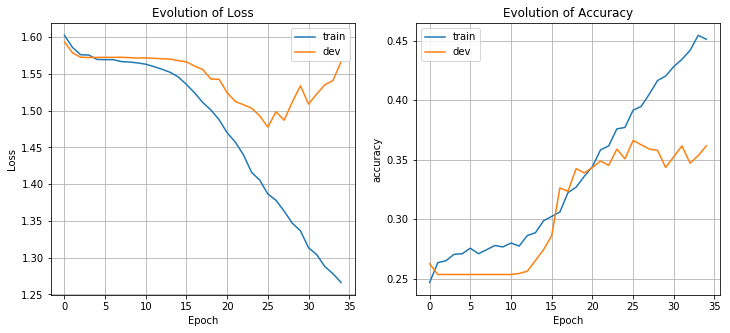

In [76]:
def plot_history(history):
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label = "train")
    plt.plot(history.history["val_loss"], label = "dev")
    plt.legend()
    plt.grid()
    plt.title("Evolution of Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"], label = "train")
    plt.plot(history.history["val_acc"], label = "dev")
    plt.legend()
    plt.grid()
    plt.title("Evolution of Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    
    plt.show()
    
plot_history(history)

In [70]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model.load_weights("models/model-026.h5")
test_pred = model.predict(x_test)
test_pred = test_pred.argmax(axis = -1).tolist()

with open(os.path.join(PATH_TO_DATA, "SST/results/logreg_lstm_y_test_sst.txt"), "w") as fp:
    fp.write("\n".join(map(str, test_pred)))

## 4.3 -- innovate !

In [13]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.preprocessing import text
from keras.layers import Flatten, Dropout, Bidirectional, Reshape, Conv2D, MaxPool2D

In [46]:
unique_word = np.unique(sum([sent.split() for sent in train_sents + dev_sents + test_sents], []))
num_words = unique_word.shape[0]

tokenizer = text.Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sents + dev_sents + test_sents)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_sents), maxlen = 50)
X_val = pad_sequences(tokenizer.texts_to_sequences(dev_sents), maxlen = 50)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_sents), maxlen = 50)

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax = 200000)
word_idx = tokenizer.word_index
my_num_words = len(word_idx) + 1
embed_mat = np.zeros((my_num_words, 300))

for word, i in word_idx.items():
    if word in w2v.word2vec:
        embed_mat[i] = w2v.word2vec[word]

In [57]:
def my_model(n_classes = 5):
    
    model = Sequential()
    model.add(Embedding(my_num_words, 300, weights = [embed_mat], input_length = 50))
    model.add(Dropout(0.7))
    model.add(Bidirectional(LSTM(300, return_sequences = True), merge_mode = 'sum'))
    model.add(Dropout(0.7))
    model.add(Reshape((-1, 300, 1)))
    
    model.add(Conv2D(100, kernel_size = (3, 3), padding = 'valid', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.7))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    return model

In [58]:
model_opt = my_model()
print(model_opt.summary())
model_opt.compile(loss = loss_classif,
                  optimizer = optimizer,
                  metrics = metrics_classif)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 300)           5352000   
_________________________________________________________________
dropout_28 (Dropout)         (None, 50, 300)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 50, 300)           1442400   
_________________________________________________________________
dropout_29 (Dropout)         (None, 50, 300)           0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 50, 300, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 298, 100)      1000      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 149, 100)      0         
__________

In [59]:
bs = 64
n_epochs = 5

checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5', verbose = 1, monitor = 'val_loss',save_best_only = True, mode = 'auto') 
history = model_opt.fit(X_train, y_train, batch_size = bs, callbacks = [checkpoint], epochs = n_epochs, validation_data = (X_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 21s 2ms/step - loss: 1.5025 - acc: 0.3220 - val_loss: 1.3971 - val_acc: 0.3933

Epoch 00001: val_loss improved from inf to 1.39708, saving model to models/model-001.h5
Epoch 2/5
8544/8544 [==============================] - 18s 2ms/step - loss: 1.3286 - acc: 0.4039 - val_loss: 1.3069 - val_acc: 0.4024

Epoch 00002: val_loss improved from 1.39708 to 1.30692, saving model to models/model-002.h5
Epoch 3/5
8544/8544 [==============================] - 18s 2ms/step - loss: 1.2283 - acc: 0.4307 - val_loss: 1.2920 - val_acc: 0.3987

Epoch 00003: val_loss improved from 1.30692 to 1.29198, saving model to models/model-003.h5
Epoch 4/5
8544/8544 [==============================] - 18s 2ms/step - loss: 1.1502 - acc: 0.4539 - val_loss: 1.2875 - val_acc: 0.4015

Epoch 00004: val_loss improved from 1.29198 to 1.28754, saving model to models/model-004.h5
Epoch 5/5
8544/8544 [===========================

In [60]:
model_opt.load_weights("models/model-004.h5")
test_pred = model_opt.predict(X_test)
test_pred = test_pred.argmax(axis = -1).tolist()

with open(os.path.join(PATH_TO_DATA, "SST/results/logreg_bilstm2_y_test_sst.txt"), "w") as fp:
    fp.write("\n".join(map(str, test_pred)))